#**Name: Akash Badhautiya**

**Roll Number: 24AI60R43**

Task1:

Load and preprocess the UCI [Vehicle silhouettes](https://archive.ics.uci.edu/dataset/149/statlog+vehicle+silhouettes) - there are 18 features in this dataset

In [1]:
pip install ucimlrepo

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from ucimlrepo import fetch_ucirepo


In [2]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
statlog_vehicle_silhouettes = fetch_ucirepo(id=149)

# data (as pandas dataframes)
X = statlog_vehicle_silhouettes.data.features
y = statlog_vehicle_silhouettes.data.targets

# metadata
print(statlog_vehicle_silhouettes.metadata)

# variable information
print(statlog_vehicle_silhouettes.variables)


{'uci_id': 149, 'name': 'Statlog (Vehicle Silhouettes)', 'repository_url': 'https://archive.ics.uci.edu/dataset/149/statlog+vehicle+silhouettes', 'data_url': 'https://archive.ics.uci.edu/static/public/149/data.csv', 'abstract': '3D objects within a 2D image by application of an ensemble of shape feature extractors to the 2D silhouettes of the objects.', 'area': 'Other', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 946, 'num_features': 18, 'feature_types': ['Integer'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': None, 'last_updated': 'Fri Feb 16 2024', 'dataset_doi': '10.24432/C5HG6N', 'creators': ['Pete Mowforth', 'Barry Shepherd'], 'intro_paper': {'ID': 393, 'type': 'NATIVE', 'title': 'Vehicle Recognition Using Rule Based Methods', 'authors': 'J. Siebert', 'venue': 'Turing Institute', 'year': 1987, 'journal': None, 'DOI': None, 'URL': 'https:

Task 2: Handle Duplicates and Missing Values, Split Dataset

1.Check for duplicates and handle them.

2.Check for missing values.

3.Partition the data into training and test sets (80%-20%).

In [4]:
# Check and remove duplicates
X = X.drop_duplicates()
print("Shape after removing duplicates:", X.shape)

# Check for missing values
missing_values = X.isnull().sum()
print("Missing values per column:\n", missing_values)

# Fill missing values or drop rows (based on data characteristics)
# Example: Filling missing values with mean
X.fillna(X.mean(), inplace=True)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Shape after removing duplicates: (846, 18)
Missing values per column:
 COMPACTNESS                         1
CIRCULARITY                         0
DISTANCE CIRCULARITY                0
RADIUS RATIO                        0
PR.AXIS ASPECT RATIO                0
MAX.LENGTH ASPECT RATIO             0
SCATTER RATIO                       0
ELONGATEDNESS                       0
PR.AXIS RECTANGULARITY              0
MAX.LENGTH RECTANGULARITY           0
SCALED VARIANCE ALONG MAJOR AXIS    0
SCALED VARIANCE ALONG MINOR AXIS    0
SCALED RADIUS OF GYRATION           0
SKEWNESS ABOUT MAJOR AXIS           0
SKEWNESS ABOUT MINOR AXIS           0
KURTOSIS ABOUT MINOR AXIS           0
KURTOSIS ABOUT MAJOR AXIS           0
HOLLOWS RATIO                       0
dtype: int64


Task 3: Implement HAC from Scratch

In [5]:
def hac_from_scratch(X, num_clusters=4):
    clusters = {i: [x] for i, x in enumerate(X)}
    while len(clusters) > num_clusters:
        min_dist = float('inf')
        to_merge = (None, None)

        cluster_ids = list(clusters.keys())
        for i in range(len(cluster_ids)):
            for j in range(i + 1, len(cluster_ids)):
                ci, cj = cluster_ids[i], cluster_ids[j]
                dist = cdist(clusters[ci], clusters[cj], metric='euclidean').mean()

                if dist < min_dist:
                    min_dist = dist
                    to_merge = (ci, cj)

        # Merge closest clusters
        ci, cj = to_merge
        clusters[ci].extend(clusters[cj])
        del clusters[cj]

    # Assign labels to clusters
    labels = np.zeros(len(X), dtype=int)
    for label, points in clusters.items():
        for point in points:
            idx = np.where((X == point).all(axis=1))[0]
            labels[idx] = label

    return labels

# Perform HAC from scratch
custom_labels = hac_from_scratch(X_train.to_numpy())


Task 4: Clustering Using sklearn's HAC Implementation

In [8]:
# sklearn's HAC implementation
sklearn_hac = AgglomerativeClustering(n_clusters=4, linkage='average') # Remove affinity argument
sklearn_labels = sklearn_hac.fit_predict(X_train)

Task 5: Generate the Dendrogram

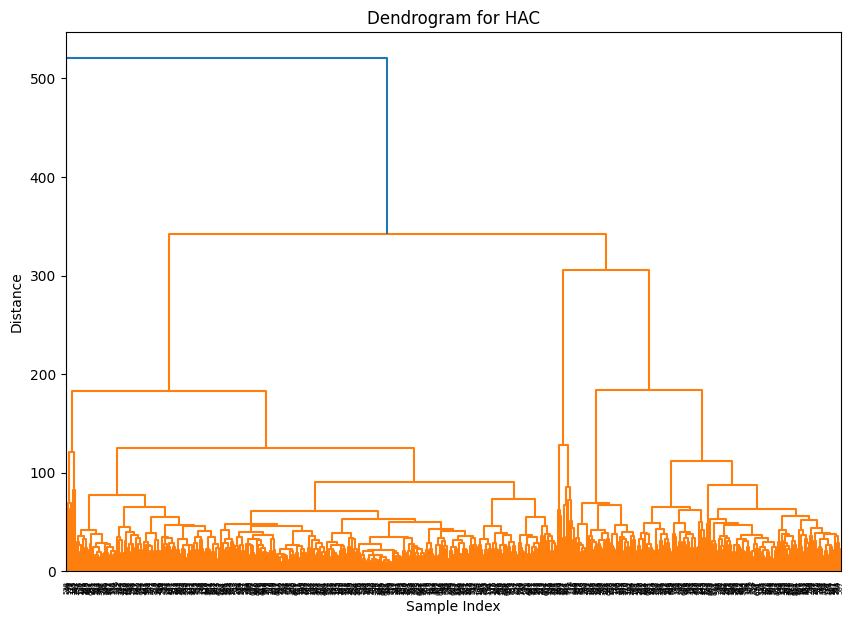

In [9]:
# Generate linkage matrix for dendrogram
Z = linkage(X_train, method='average', metric='euclidean')

# Plot dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title("Dendrogram for HAC")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()


Task 6: Consistent Labeling

In [13]:
def sort_clusters_by_centroid(X, labels):
    unique_labels = np.unique(labels)
    centroids = [X[labels == label].mean(axis=0) for label in unique_labels]
    sorted_labels = np.argsort([np.linalg.norm(centroid) for centroid in centroids])

    # Create a label map that handles missing keys
    label_map = {original_label: i for i, original_label in enumerate(unique_labels[sorted_labels])}

    # Use a lambda function to handle missing keys and avoid None values
    standardized_labels = np.vectorize(lambda x: label_map.get(x, -1))(labels)

    return standardized_labels
# Standardize labels
custom_labels_sorted = sort_clusters_by_centroid(X_train.to_numpy(), custom_labels)
sklearn_labels_sorted = sort_clusters_by_centroid(X_train.to_numpy(), sklearn_labels)

Task 7: Compare Label Consistency

In [14]:
# Calculate percentage of matching labels
match_percentage = (custom_labels_sorted == sklearn_labels_sorted).mean() * 100
print(f"Percentage of matching labels: {match_percentage:.2f}%")


Percentage of matching labels: 100.00%


Task 8: Report Cluster Consistency with Ground Truth Labels

In [15]:
def report_cluster_consistency(X, y, labels):
    cluster_consistency = {}
    for label in np.unique(labels):
        cluster_indices = np.where(labels == label)[0]
        cluster_labels = y.iloc[cluster_indices]
        class_counts = cluster_labels.value_counts(normalize=True)
        cluster_consistency[label] = class_counts.to_dict()
    return cluster_consistency

# Consistency for custom implementation
custom_consistency = report_cluster_consistency(X_train, y_train, custom_labels_sorted)
print("Cluster consistency for custom HAC implementation:", custom_consistency)

# Consistency for sklearn implementation
sklearn_consistency = report_cluster_consistency(X_train, y_train, sklearn_labels_sorted)
print("Cluster consistency for sklearn HAC implementation:", sklearn_consistency)


Cluster consistency for custom HAC implementation: {0: {('van',): 0.37149532710280375, ('bus',): 0.2827102803738318, ('opel',): 0.1822429906542056, ('saab',): 0.16355140186915887}, 1: {('204',): 1.0}, 2: {('opel',): 0.4482758620689655, ('saab',): 0.4267241379310345, ('bus',): 0.125}, 3: {('bus',): 1.0}}
Cluster consistency for sklearn HAC implementation: {0: {('van',): 0.37149532710280375, ('bus',): 0.2827102803738318, ('opel',): 0.1822429906542056, ('saab',): 0.16355140186915887}, 1: {('204',): 1.0}, 2: {('opel',): 0.4482758620689655, ('saab',): 0.4267241379310345, ('bus',): 0.125}, 3: {('bus',): 1.0}}
